In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math


from architectures.resCNN import *

In [2]:
# some constants

LEARNING_RATE = 0.0095
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 5000
SAVE_SAMPLE_PERIOD = 1000
task = 'TRAIN'
#task = 'TEST'
PATH='resCNN_test'
SEED=1




In [3]:
trunc_normal= tf.truncated_normal_initializer(stddev=1, seed=SEED)
normal = tf.random_normal_initializer(stddev=1, seed=SEED)
uniform = tf.random_uniform_initializer(seed=SEED)

global sizes
sizes = {
        
        'conv_layer_0':[(2, 8, 2, False, 0.7, lrelu, normal)],
        'convblock_layer_0': [(8, 2, 1, 'bn', 0.7, lrelu, normal),
                              (16, 4, 2, 'bn', 0.7, lrelu, normal),
                             (24, 4, 1, 'bn', 0.7, lrelu, normal)],
        'convblock_shortcut_layer_0':[(24, 1, 2, 'bn', 0.7, normal)],
        #
        'avgpool_layer_0':[(2, 2, 1)],
        'convblock_layer_1': [(24, 4, 1, 'bn', 0.7, lrelu, normal),
                              (36, 8, 2, 'bn', 0.7, lrelu, normal),
                             (64, 16, 1, 'bn', 0.7, lrelu, normal)],
        'convblock_shortcut_layer_1':[(64, 1, 2, 'bn', 0.7, normal)],
        
        'avgpool_layer_1':[(2, 2, 1)],
        'dense_layers':[(512, 'bn', 0.5, tf.nn.relu, normal),
                       (128, 'bn', 0.5, tf.nn.relu, normal),
                       (64, False, 0.5, tf.nn.relu, normal)],
        
        'n_classes':10,
        'readout_w_init':uniform
         
}

In [4]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

    X_train = mnist.train.images
    Y_train = mnist.train.labels
    
    X_train = X_train.reshape(len(X_train),28,28,1)
    Y_train = Y_train.reshape(len(Y_train),10)
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    
    X_test = X_test.reshape(len(X_test),28,28,1)
    Y_test =  Y_test.reshape(len(Y_test),10)
    
    tf.reset_default_graph()
    cnn = resCNN(n_H, n_W, n_C, sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            cnn.set_session(sess)
            cnn.fit(X_train, Y_train, X_test, Y_test)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            cnn.set_session(sess)

           
        done = False
        while not done:
            
            i = np.random.choice(len(X_test))
            x = X_test[i].reshape(X_test.shape[1],X_test.shape[2],X_test.shape[3])
            ground_truth=np.where(Y_test[i]>0)[0][0]
            p = cnn.predicted_Y_hat([x]).reshape(sizes['n_classes'])
            prediction = np.where(p==np.max(p))[0][0]
            
            
            plt.clf()
            plt.imshow(x.reshape(
                                X_test.shape[1],
                                X_test.shape[2]),
                                cmap='gray'
                      )
            plt.title('Input image')
            plt.show()
            
            print('True class: '+str(ground_truth)+'\n'+
                  'Predicted class: '+str(prediction)+'\n')
                  
            
            

            ans = input("Predict another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolution
Input for convolution shape  (?, 28, 28, 1)
Convolution_block_1
Input shape (?, 28, 28, 1)
Convolution_block_2
Input shape (?, 14, 14, 2)
Convolution_block_3
Input shape (?, 7, 7, 24)
Convolution_block_4
Input shape (?, 4, 4, 24)
Convolution_block_5
Input shape (?, 2, 2, 64)
Logits shape (?, 10)
Convolution
Input for convolution shape  (?, 28, 28, 1)
Convolution_block_1
Input shape (?, 28, 28, 1)
Convolution_block_2
Input shape (?, 14, 14, 2)
Convolution_block_3
Input shape (?, 7, 7, 24)
Convolution_block_4
Input shape (?, 4, 4, 24)
Convolution_block_5
Input shape (?, 2, 2, 64)
Logits shape (?, 10)

 Training...

 ****** 

Training residual CNN for 5000 epochs with a total of 55000 samples
distributed in 429 batches of size 128

The learning rate set is 0.0095

 ****** 

Evaluating p

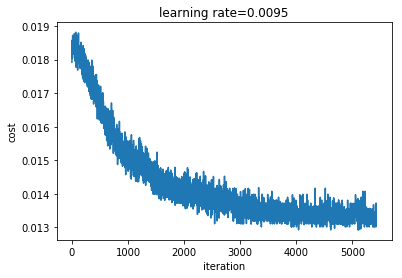

Parameters trained
Model saved in path: resCNN_test/resCNN_test.ckpt


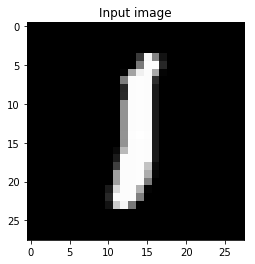

True class: 1
Predicted class: 1

Predict another?


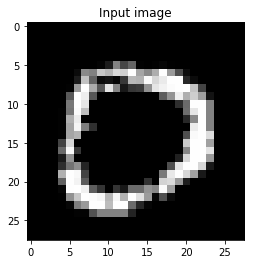

True class: 0
Predicted class: 0

Predict another?


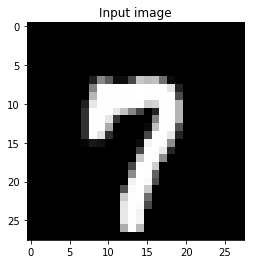

True class: 7
Predicted class: 7

Predict another?


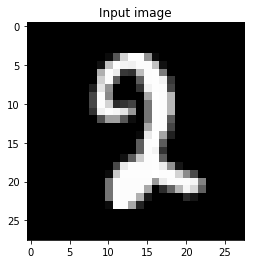

True class: 2
Predicted class: 1

Predict another?n


In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()